### House Pricing Regression Model

This project runs a Regression analysis among the variables, price variation, difference between all house features. in order to answer our business questions:
* What are the expected house features for average prices based on our analysis?
* What are the most effective house features in pricing?
* How well can we predict the house pricing ?

**The data that we are using in our project is collected from kaggel**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from IPython.display import display,HTML
import seaborn as sns
import math
from tabulate import tabulate
import datasist as ds


import IPython as display
%matplotlib inline

In [2]:
df = pd.read_csv("C:\\Users\\PC\\Documents\\GitHub\\project1\\house_data.csv")
df.head()

,id,date,price,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
df.price.describe().apply(lambda x: format(x, 'f'))

count      21613.000000
mean      540182.158793
std       367362.231718
min        75000.000000
25%       321950.000000
50%       450000.000000
75%       645000.000000
max      7700000.000000
Name: price, dtype: object

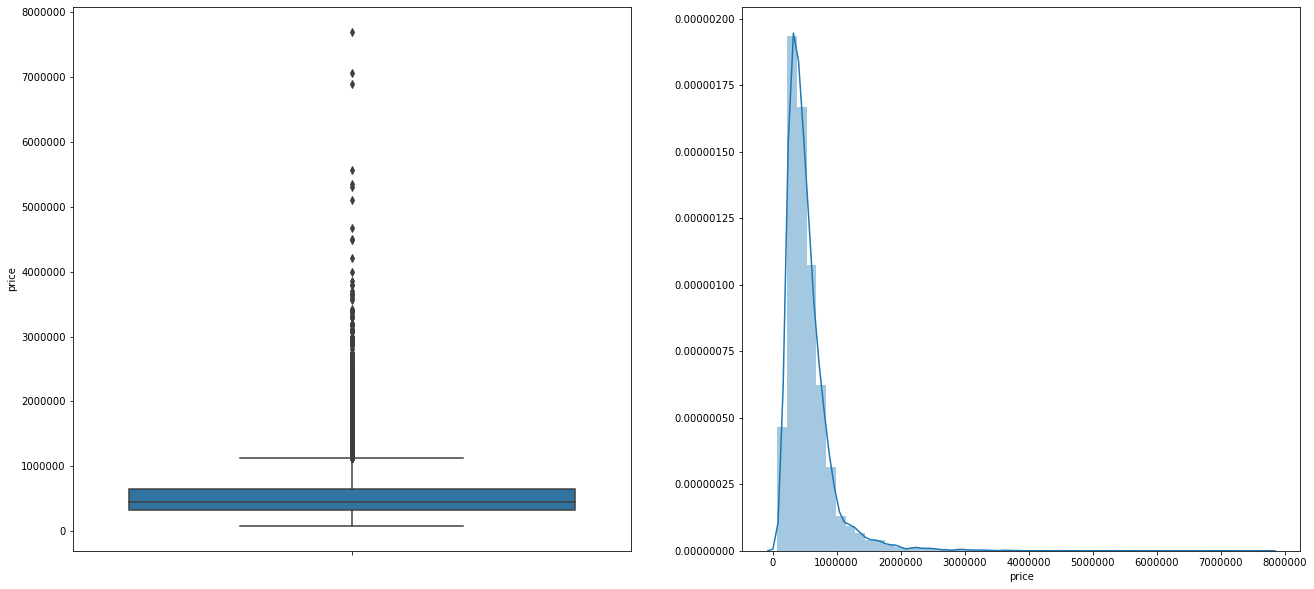

In [15]:
plt.figure(figsize=(22, 10))

plt.subplot(1,2,2)
sns.distplot(df['price']);
plt.subplot(1,2,1)
sns.boxplot(y=df['price']);
plt.show()

#### *Most of the density lies between 75k and 100k, but there appears to be a lot of outliers on the pricier side.*

# **1. What are the expected house features for average prices based on our analysis**

In [5]:
# what is the range of house pricing for medium houses

# First we have to identify the aspects related to house size , 'bedrooms','bathrooms','sqft_living','sqft_lot'

price_mid_hs = df[['price','bedrooms','bathrooms','sqft_living15','sqft_lot15','grade']]
# print(price_mid_hs.shape)

#now we have all house sizing aspects in standalone DataFrame, we can the medium of the messurement and compare it with size. First drop all prices that are above the mean.

# 1. Count the Price mean
Price_mean = price_mid_hs.price.mean()
# print(Price_mean)

# 2. remove any raw that hold any price larger than the mean
md_price_mid_hs = price_mid_hs[price_mid_hs.price < Price_mean]
# print(md_price_mid_hs.shape)

new_Price_mean  = math.floor(md_price_mid_hs.price.mean())
# print(new_Price_mean)

# 3. Count all mediums of all house size aspect

new_bedrooms_mean = math.floor(md_price_mid_hs.bedrooms.mean())
new_bathrooms_mean = math.floor(md_price_mid_hs.bathrooms.mean())
new_sqft_living_mean = math.floor(md_price_mid_hs.sqft_living15.mean())
new_sqft_lot_mean = math.floor(md_price_mid_hs.sqft_lot15.mean())
new_grade_mean = math.floor(md_price_mid_hs.grade.mean())

# 4. print the result of the conclusion
data = {'aspects': ['Average Price','Expected number of bedrooms','Expected number of bathrooms','Expected size of living area sqft','Expected building size sqft lot','Expected grade'],
        'values': [new_Price_mean,new_bedrooms_mean,new_bathrooms_mean,new_sqft_living_mean,new_sqft_lot_mean,new_grade_mean]
        }
result = pd.DataFrame(data, columns = ['aspects', 'values'])

#print("We create a table of all statistics for mid priced house featurs")
print(tabulate(result, headers='keys', tablefmt='psql'))


+----+-----------------------------------+----------+
|    | aspects                           |   values |
|----+-----------------------------------+----------|
|  0 | Average Price                     |   355475 |
|  1 | Expected number of bedrooms       |        3 |
|  2 | Expected number of bathrooms      |        1 |
|  3 | Expected size of living area sqft |     1721 |
|  4 | Expected building size sqft lot   |    11065 |
|  5 | Expected grade                    |        7 |
+----+-----------------------------------+----------+


***The above table shows all statistics for mid priced house featurs***



# **2. What are the most effective house features in pricing**

In [6]:
# We create a DataFrame with all possibile factors that may affect on house pricing in order to get correlcation between factors and to pricing

predic_price = df[['price','bedrooms','bathrooms','floors','waterfront','view','condition','grade','sqft_above','sqft_basement','yr_built','yr_renovated','zipcode','lat','long','sqft_living15','sqft_lot15']]

In [32]:
# To get all correlcation to pricing ,we should get heatmap of the correlation, and we have to factorize all categorical factors in order to work
plt.figure(figsize=(15, 15))
corr = predic_price.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
# print("As we can see the correlation between all factors seem to be acceptable for us in order to build our model on them")
#sns.heatmap(corr,annot=True, fmt=".2f")
corr.style.background_gradient(cmap='coolwarm')

,price,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
price,1.000000,0.040503,0.067950,0.050377,0.025456,0.003185,-0.031739,0.109556,0.099636,-0.003885,0.002580,0.006078,-0.013825,0.074697,0.011255,0.082944,0.108943
bedrooms,0.040503,1.000000,0.224452,0.094156,0.011830,0.069492,-0.012104,0.229366,0.192587,0.130302,0.024103,0.018884,0.017329,-0.004973,0.006096,0.122090,0.008055
bathrooms,0.067950,0.224452,1.000000,0.152878,0.059993,0.124661,-0.116498,0.338406,0.233406,0.142734,0.003978,0.012198,0.041297,-0.002126,0.071326,0.144075,0.116886
floors,0.050377,0.094156,0.152878,1.000000,0.025619,0.010207,-0.175250,0.234026,0.173121,-0.109345,0.123244,0.014863,-0.051771,-0.034339,0.011004,0.071081,0.106636
waterfront,0.025456,0.011830,0.059993,0.025619,1.000000,0.180977,0.013061,0.075330,0.039491,0.051314,0.009030,0.085502,-0.023435,-0.001215,0.032205,0.039735,0.047484
view,0.003185,0.069492,0.124661,0.010207,0.180977,1.000000,0.023158,0.167896,0.053053,0.168534,0.001338,0.064995,0.003401,-0.005392,0.028168,0.079386,0.008343
condition,-0.031739,-0.012104,-0.116498,-0.175250,0.013061,0.023158,1.000000,-0.142126,-0.124158,0.054432,-0.023297,-0.028157,0.022381,0.001908,-0.026035,-0.082177,-0.104477
grade,0.109556,0.229366,0.338406,0.234026,0.075330,0.167896,-0.142126,1.000000,0.332577,0.043891,0.036160,-0.002745,0.060262,-0.003954,0.094822,0.281366,0.160148
sqft_above,0.099636,0.192587,0.233406,0.173121,0.039491,0.053053,-0.124158,0.332577,1.000000,-0.038685,0.050299,0.003079,0.016403,0.042672,0.061863,0.374308,0.142072
sqft_basement,-0.003885,0.130302,0.142734,-0.109345,0.051314,0.168534,0.054432,0.043891,-0.038685,1.000000,-0.001192,0.025220,0.016531,-0.017925,-0.042836,0.009565,0.011204


<Figure size 1080x1080 with 0 Axes>

### ***As we can see the correlation between all factors seem to be acceptable for us in order to build our model on them***

In [33]:
# Getting the highest correlated factors to the price
corr_target = abs(corr["price"])
relevant_features = corr_target[corr_target>0.10]
print(relevant_features)
# print()
# print('As we can see the most affecting factors to pricing are grade and the building area size')

price         1.000000
grade         0.109556
sqft_lot15    0.108943
Name: price, dtype: float64


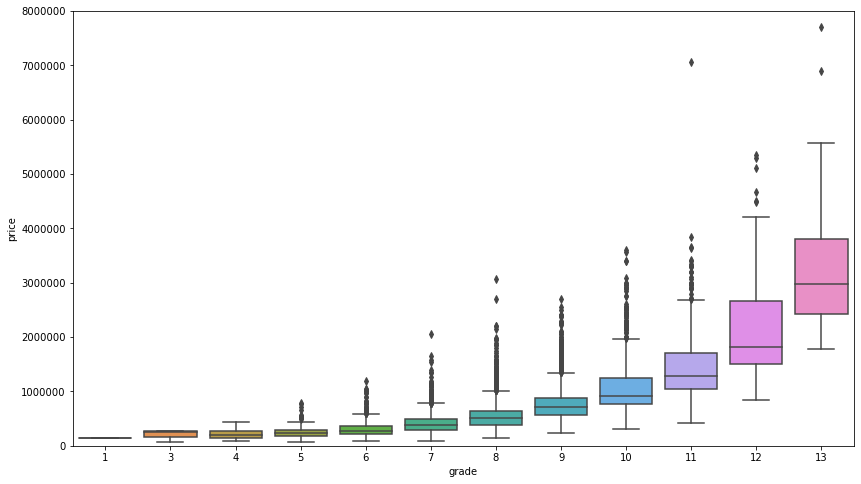

In [9]:
var = 'grade'
data = pd.concat([df['price'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(14, 8))
fig = sns.boxplot(x=var, y="price", data=data)
fig.axis(ymin=0, ymax=8000000);

### ***As we can see the most affecting factors to pricing are grade and the building area size***

# **3. How well can we predict the house pricing**

### ***In order to design a model to predic the house pricing, we have to do some data processing to make sure our data fits in our model and present a good prediction of house pricing***

* ### First, we create a function that takes the our dataframe to do the following

    * #### ***Drop every raw that holds a null value in price column***
    * #### ***Create two dataframes that hold price and others as response and explanatory variables***
    * #### ***Filling every null value in every quantitative factor by its mean***
    * #### ***Create dummies for every categorical factor***

In [35]:
def clean_data(df):
    
    df = df.dropna(subset=['price'], axis=0)
    y = df['price']
    
    #Drop respondent and expected salary columns
    df = df.drop(['price'], axis=1)
    
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        
    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    X = df
    return X, y
    
#Use the function to create X and y
X, y = clean_data(predic_price) 


In [38]:
#Split into train and test
x2n, x2t, y2n, y2t = train_test_split(X, y, test_size = 0.70, random_state = 42)

# Instantiate
lm2_model = LinearRegression(normalize=True)

#Fit
lm2_model.fit(x2n,y2n)

y_test_preds = lm2_model.predict(x2t) 

rsquared_score = r2_score(y2t, y_test_preds) 
length_y_test = len(y2t)


"The r-squared score for our model was {} on {} values.".format(rsquared_score, length_y_test)

'The r-squared score for our model was 0.6937090076175196 on 15130 values.'

#### *We found that there is a strong relationship between all given factors that affect the house pricing, The r-squared score for our model was 0.6937090076175196 on 15130 values.*